In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, optimization

## Dataset (PNAS Smart-seq-total paper)

Load dataset of single genes

In [2]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

## Capture efficiency

Estimate capture efficiency per cell from the full dataset of genes:
- set a mean value <$\beta$>
- compute the total counts per cell / total counts across all cells
- renormalize to have mean <$\beta$>, giving capture efficiency $\beta_{j}$ per cell

In [3]:
# mean beta
beta_mean = 0.1

# total counts per cell
total_per_cell = data_FIB.sum(axis='rows')

# total counts across all cells
total_overall = total_per_cell.sum()

# count proportions per cell (sum = 1)
count_proportion = (total_per_cell / total_overall).to_numpy()

# number of cells
n = count_proportion.size

# re-normalize
beta = count_proportion * beta_mean * n

# clamp values outside [0, 1]
if (beta >= 1).size > 0:
    beta[beta >= 1] = beta[beta < 1].max()
if (beta <= 0).size > 0:
    beta[beta <= 0] = beta[beta > 0].min()

In [4]:
# set mean beta
MeanBETA = 0.1

#xx<-Matrix::colSums(Data)
xx = data_FIB.sum(axis='rows')

#Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
# Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
Normcount = (data_FIB / xx) * np.mean(xx) # sum = mean(xx) per column

#means <- Matrix::rowMeans(Normcount)
means = Normcount.mean(axis='columns')

#lmeans <- log(means)
lmean = np.log(means)

#med <- apply(log(Normcount + 1), 1, function(x) {
#    median(x)
#})
med = np.log(Normcount + 1).median(axis=1)

#mad <- apply(log(Normcount + 1), 1, function(x) {
#    mad(x)
#})
mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

#bound <- med + 3 * mad
bound = med + 3*mad

#maxlogGene <- apply(log(Normcount + 1), 1, max)
maxlogGene = np.log(Normcount + 1).max(axis=1)

#ind <- which(maxlogGene < bound)
ind = maxlogGene < bound

#dropout = apply(Data, 1, function(x) {
#    length(which(x == 0))/length(x)
#})
dropout = data_FIB.apply(lambda row: (row == 0).sum() / row.size, axis=1)


#Select_ind <- intersect(ind, which(dropout < 0.35))
Select_ind = ind & (dropout < 0.35)

# Selected_genes <- rownames(Data)[Select_ind]
Selected_genes = list(Select_ind.index)

#temppp <- Matrix::colSums(Data[Select_ind, ])
temppp = data_FIB[Select_ind].sum(axis=0)

#BETA <- temppp/mean(temppp) * MeanBETA
BETA = (temppp / temppp.mean()) * MeanBETA

#if (length(which(BETA >= 1)) > 0) {
#    BETA[BETA >= 1] = max(BETA[BETA < 1])
#}
#if (length(which(BETA <= 0)) > 0) {
#    BETA[BETA <= 0] = min(BETA[BETA > 0])
#}
if (BETA >= 1).size > 0:
    BETA[BETA >= 1] = BETA[BETA < 1].max()
if (BETA <= 0).size > 0:
    BETA[BETA <= 0] = BETA[BETA > 0].min()

#names(BETA) <- colnames(Data)

#return(list(BETA = BETA, Selected_genes = Selected_genes))
BETA = BETA.to_numpy()

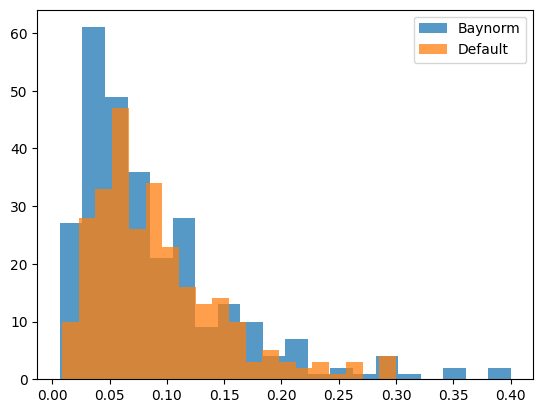

In [5]:
plt.hist(BETA, bins=20, alpha=0.75, label="Baynorm");
plt.hist(beta, bins=20, alpha=0.75, label="Default");
plt.legend()

## Construct dataset of pairs

Avoid repeating pairs as symmetric

In [6]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = data_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = data_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_FIB = dataset.Dataset("dataset_FIB")
dataset_FIB.count_dataset = counts_df
dataset_FIB.cells = cells
dataset_FIB.gene_pairs = gene_pairs

# settings
dataset_FIB.thresh_OB = 3
dataset_FIB.threshM_OB = 3

# set capture
dataset_FIB.beta = BETA

### Moment optimization

In [8]:
# memory settings
dataset_FIB.resamples = 1000

In [9]:
dataset_FIB.compute_moments(tqdm_disable=False)

100%|██████████| 5050/5050 [01:20<00:00, 62.81it/s]


In [10]:
# optimization analysis
moment_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

100%|██████████| 5050/5050 [01:19<00:00, 63.83it/s]


In [48]:
moment_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            if moment_FIB.result_dict[k]['status'] == "INFEASIBLE":
                moment_array[i, j] = 1
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_array[i, j] = moment_array[j, i]

# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 110.0, 'Optimization using moment CIs to test independence         \nBlue: feasible, independent pair          \nRed: infeasible, interacting pair')

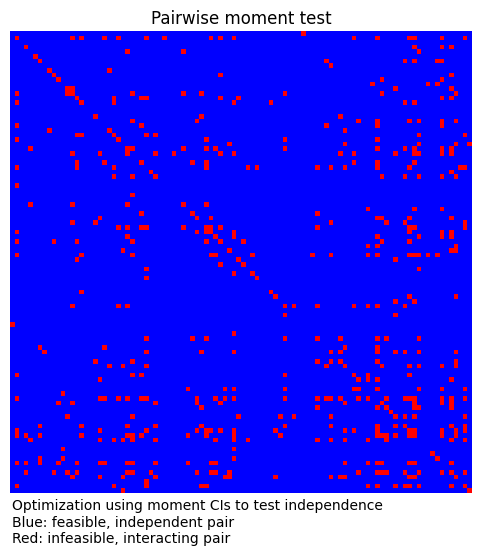

In [49]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(moment_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise moment test")
plt.axis('off')
plt.text(0.0, 110.0, "Optimization using moment CIs to test independence\
         \nBlue: feasible, independent pair \
         \nRed: infeasible, interacting pair")
#cbar = plt.colorbar(img, ax=axs)
#cbar.set_label("p-value")

#### Correlations of moment-infeasible pairs

In [221]:
import scipy

moment_blackout_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        if j > i:
            pass
        else:
            if moment_array[i, j] == 1:
                # change infeasible pairs value to correlation

                # get sample
                sample = moment_FIB.dataset.count_dataset.loc[f'Gene-pair-{k}']
                x1_sample = [x[0] for x in sample]
                x2_sample = [x[1] for x in sample]

                # correlation test
                pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

                # store statistic
                moment_blackout_array[i, j] = float(pearson.statistic)

            else:
                # set feasible pairs to 0
                moment_blackout_array[i, j] = None
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_blackout_array[i, j] = moment_blackout_array[j, i]

# optional delete diagonal
for k in range(genes):
    moment_blackout_array[k, k] = None

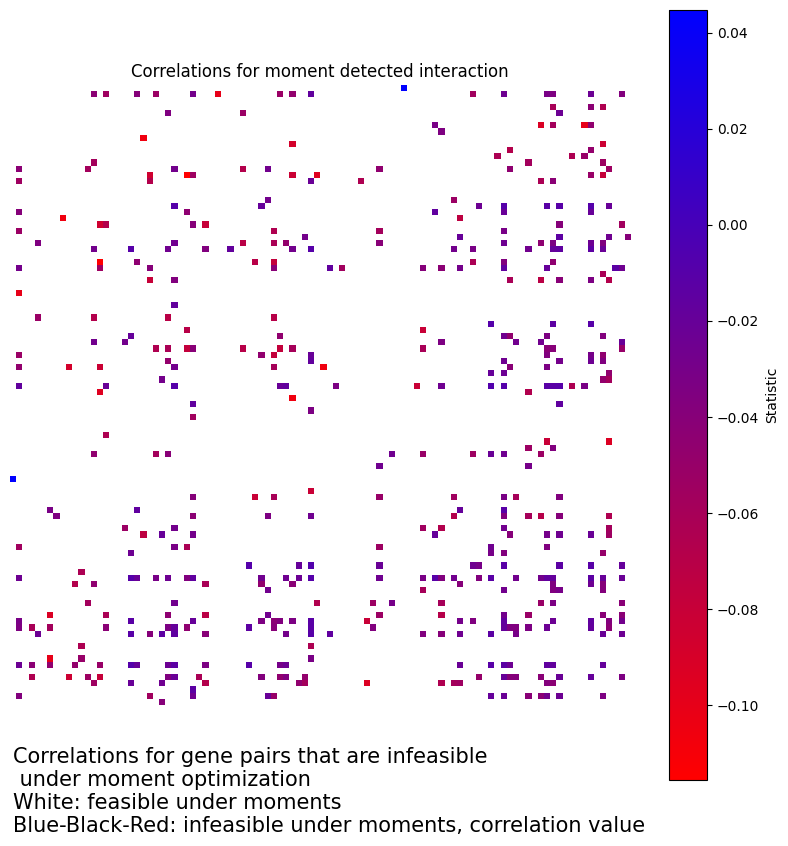

In [222]:
fig, axs = plt.subplots(figsize=(10, 10))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (1, "b")], N=256)
vmin, vmax = np.nanmin(moment_blackout_array), np.nanmax(moment_blackout_array)
img = axs.imshow(moment_blackout_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Correlations for moment detected interaction")
plt.axis('off')
plt.text(0.0, 120.0, 
         "Correlations for gene pairs that are infeasible \n under moment optimization\
         \nWhite: feasible under moments \
         \nBlue-Black-Red: infeasible under moments, correlation value",
         size=15)
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("Statistic")

#### Correlation of moment-feasible pairs

In [223]:
import scipy

moment_whiteout_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        if j > i:
            pass
        else:
            if moment_array[i, j] == 0:
                # change feasible pairs value to correlation

                # get sample
                sample = moment_FIB.dataset.count_dataset.loc[f'Gene-pair-{k}']
                x1_sample = [x[0] for x in sample]
                x2_sample = [x[1] for x in sample]

                # correlation test
                pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

                # store statistic
                moment_whiteout_array[i, j] = float(pearson.statistic)

            else:
                # set infeasible pairs to 0
                moment_whiteout_array[i, j] = None
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_whiteout_array[i, j] = moment_whiteout_array[j, i]

# optional delete diagonal
for k in range(genes):
    moment_whiteout_array[k, k] = None

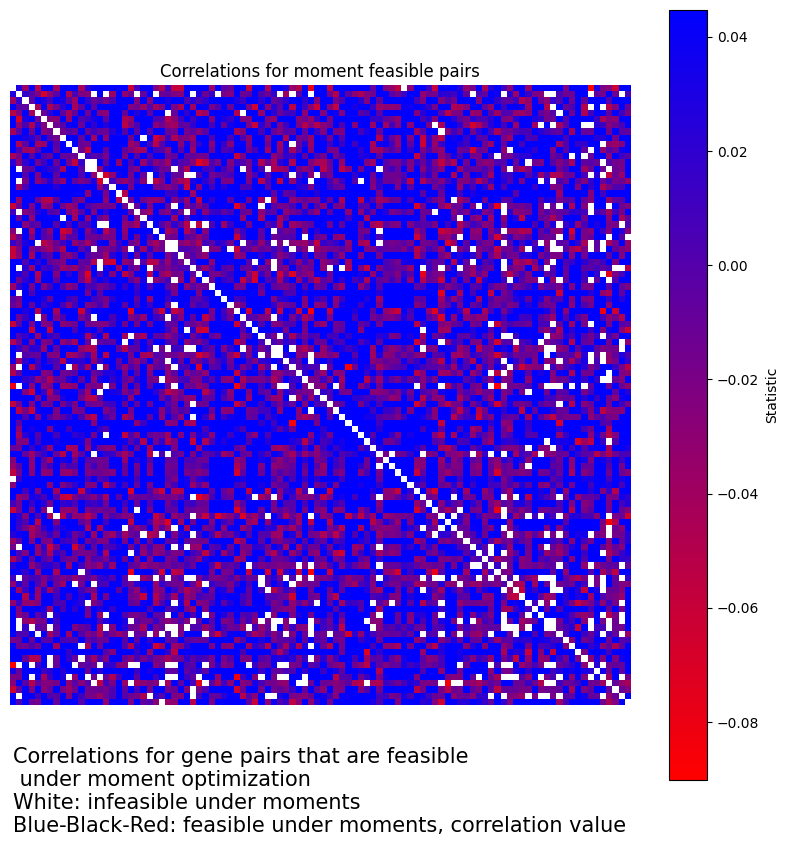

In [224]:
fig, axs = plt.subplots(figsize=(10, 10))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (1, "b")], N=256)
vmin, vmax = np.nanmin(moment_whiteout_array), np.nanmax(moment_blackout_array)
img = axs.imshow(moment_whiteout_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Correlations for moment feasible pairs")
plt.axis('off')
plt.text(0.0, 120.0, 
         "Correlations for gene pairs that are feasible \n under moment optimization\
         \nWhite: infeasible under moments \
         \nBlue-Black-Red: feasible under moments, correlation value",
         size=15)
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("Statistic")

### Independent Birth-Death optimization

In [44]:
dataset_FIB.bootstrap_marginal_fm(tqdm_disable=False)

100%|██████████| 5050/5050 [00:42<00:00, 119.01it/s]


In [45]:
dataset_FIB.bootstrap_marginal_probabilities(tqdm_disable=False)

100%|██████████| 5050/5050 [02:37<00:00, 32.05it/s]


In [50]:
# optimization analysis
indep_BD_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_1",
        "downsampled_marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

 63%|██████▎   | 3160/5050 [1:02:00<1:06:22,  2.11s/it] Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 63%|██████▎   | 3196

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 66%|██████▌   | 3319/5050 [1:02:08<05:34,  5.17it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 67%|██████▋   | 3400/5050 [1:07:15<2:06:24,  4.60s/it] Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 69%|██████▉   | 3482/5050 [1:07:26<08:02,  3.25it/s]  Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 71%|███████   | 3565/5050 [1:07:32<03:59,  6.20it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 72%|███████▏  | 3649/5050 [1:07:43<07:16,  3.21it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 74%|███████▍  | 3734/5050 [1:07:52<05:08,  4.26it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 74%|███████▍  | 3741/5050 [1:07:53<02:58,  7.32it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 74%|███████▍  | 3755

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 75%|███████▍  | 3769

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 77%|███████▋  | 3907/5050 [1:13:03<1:13:56,  3.88s/it] Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 78%|███████▊  | 3914/5050 [1:13:03<25:03,  1.32s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 79%|███████▉  | 3994/5050 [1:18:09<1:16:35,  4.35s/it] Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 79%|███████▉  | 4001/5050 [1:18:11<29:36,  1.69s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 81%|████████  | 4084/5050 [1:23:45<22:36,  1.40s/it]   Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 81%|████████  | 4091/5050 [1:23:47<08:29,  1.88it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 83%|████████▎ | 4174/5050 [1:28:58<56:59,  3.90s/it]   Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is ou

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 83%|████████▎ | 4181/5050 [1:28:59<19:13,  1.33s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 84%|████████▍ | 4265/5050 [1:29:06<02:04,  6.32it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 85%|████████▍ | 4271/5050 [1:29:06<01:18,  9.95it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 86%|████████▋ | 4356/5050 [1:29:12<00:42, 16.28it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 86%|████████▋ | 4363/5050 [1:29:13<01:16,  8.98it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 87%|████████▋ | 4371/5050 [1:29:14<00:56, 12.07it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 87%|████████▋ | 4385

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 87%|████████▋ | 4398

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 90%|████████▉ | 4544/5050 [1:29:35<05:29,  1.53it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 90%|█████████ | 4551/5050 [1:29:36<02:10,  3.82it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 90%|█████████ | 4558/5050 [1:29:38<02:05,  3.92it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 92%|█████████▏| 4639/5050 [1:34:46<32:32,  4.75s/it]  Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 92%|█████████▏| 4645/5050 [1:34:46<14:28,  2.14s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 92%|█████████▏| 4650/5050 [1:34:47<07:49,  1.17s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 94%|█████████▍| 4735/5050 [1:34:54<00:53,  5.84it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 94%|█████████▍| 4742/5050 [1:34:54<00:30, 10.25it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 94%|█████████▍| 4747/5050 [1:34:55<00:30,  9.90it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 96%|█████████▌| 4832/5050 [1:35:04<01:04,  3.38it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 96%|█████████▌| 4839/5050 [1:35:05<00:32,  6.55it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 96%|█████████▌| 4845/5050 [1:35:06<00:29,  6.99it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 96%|█████████▌| 4850/5050 [1:35:06<00:24,  8.19it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


100%|█████████▉| 5029/5050 [1:35:15<00:04,  5.10it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


100%|█████████▉| 5036/5050 [1:35:16<00:01,  9.41it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


100%|█████████▉| 5041/5050 [1:35:16<00:00,  9.21it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


100%|█████████▉| 5048/5050 [1:35:16<00:00, 12.12it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out o

Optimization failed: index 1 is out of bounds for axis 0 with size 1


In [72]:
indep_BD_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            if indep_BD_FIB.result_dict[k]['status'] == "INFEASIBLE":
                indep_BD_array[i, j] = 1
            elif indep_BD_FIB.result_dict[k]['status'] == "OPTIMAL":
                indep_BD_array[i, j] = 0
            else:
                indep_BD_array[i, j] = 0.5
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            indep_BD_array[i, j] = indep_BD_array[j, i]

# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 110.0, 'Optimization using marginal prob. CIs         \nBlue: feasible, independent birth-death pair          \nRed: infeasible          \nWhite: optimization failure')

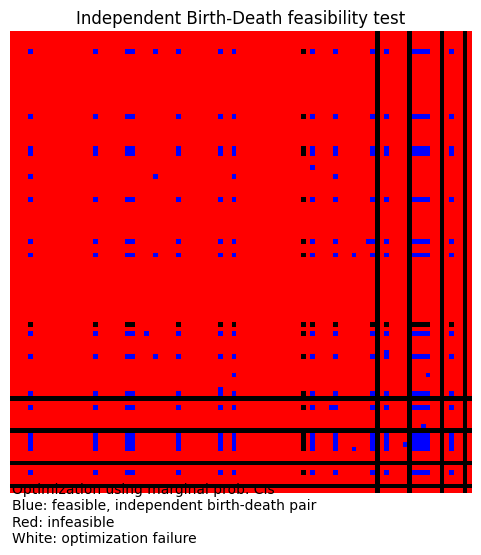

In [153]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "k"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_BD_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Birth-Death feasibility test")
plt.axis('off')
plt.text(0.0, 110.0, "Optimization using marginal prob. CIs\
         \nBlue: feasible, independent birth-death pair \
         \nRed: infeasible \
         \nWhite: optimization failure")

#### Why does this not agree with individual sample birth death feasibility tests?

## Construct dataset single genes (paired to save space)

i.e. (X1, X2), (X3, X4), ... 

for marginal optimization

In [56]:
# size
genes = 100
gene_pairs = genes // 2
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
i = 0
for k in range(gene_pairs):
    gene_i = data_FIB.iloc[i]
    gene_j = data_FIB.iloc[i + 1]
    gene_pair_ij = list(zip(gene_i, gene_j))
    counts_df.iloc[k] = gene_pair_ij
    i += 2

# construct object
dataset_single_FIB = dataset.Dataset("dataset_single_FIB")
dataset_single_FIB.count_dataset = counts_df
dataset_single_FIB.cells = cells
dataset_single_FIB.gene_pairs = gene_pairs

# settings
dataset_FIB.thresh_OB = 3
dataset_FIB.threshM_OB = 3

# set capture
dataset_single_FIB.beta = BETA

### Marginal optimization

In [57]:
# memory details
dataset_single_FIB.splits = 10
dataset_single_FIB.resamples = 1000

In [58]:
dataset_single_FIB.bootstrap_marginal_probabilities(tqdm_disable=False)

100%|██████████| 50/50 [00:01<00:00, 28.09it/s]


In [59]:
dataset_single_FIB.bootstrap_marginal_fm(tqdm_disable=False)

100%|██████████| 50/50 [00:00<00:00, 145.31it/s]


### Birth-Death

In [60]:
# optimization analysis
odd_results_BD = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

  2%|▏         | 1/50 [00:00<00:16,  3.00it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bound

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 38%|███▊      | 19/50 [00:00<00:00, 36.24it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of boun

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 64%|██████▍   | 32/50 [00:00<00:00, 44.68it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of boun

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 315, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 918, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
100%|██████████| 50/5

Optimization failed: index 1 is out of bounds for axis 0 with size 1


In [61]:
# optimization analysis
even_results_BD = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_2",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

  0%|          | 0/50 [00:00<?, ?it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for ax

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recen

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
 54%|█████▍    | 27/5

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 68%|██████▊   | 34/50 [00:18<00:17,  1.06s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of boun

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 90%|█████████ | 45/50 [02:19<00:41,  8.27s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 322, in add_constraints
    add_downsampled_marginal_CME_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 954, in add_downsampled_marginal_CME_2_constraints
    z == k_deg_2 * pd2[1] - k_tx_2 * fm2[0] * pd2[0],
                   ~~~^^^
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of boun

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


In [63]:
# combine results of feasibility test
feasible_results_BD = []
for k in range(gene_pairs):
    feasible_results_BD.append(even_results_BD.result_dict[k]['status'])
    feasible_results_BD.append(odd_results_BD.result_dict[k]['status'])

42 Failed 
44 Feasible 
14 Infeasible


Text(0.5, 1.0, 'Independent Birth-Death feasiblity tests')

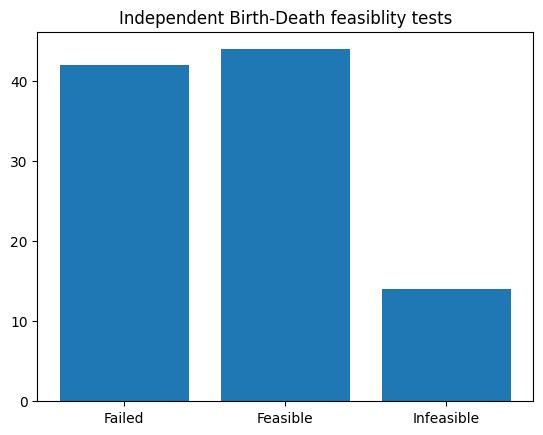

In [64]:
num_failed = (np.array(feasible_results_BD) == None).sum()
num_feasible = (np.array(feasible_results_BD) == 'OPTIMAL').sum()
num_infeasible = (np.array(feasible_results_BD) == 'INFEASIBLE').sum()

print(f"{num_failed} Failed \n{num_feasible} Feasible \n{num_infeasible} Infeasible")

plt.bar(["Failed", "Feasible", "Infeasible"], [num_failed, num_feasible, num_infeasible]);
plt.title("Independent Birth-Death feasiblity tests")

In [113]:
indep_BD_array_2 = np.zeros((genes, genes))
for i in range(genes):
    for j in range(genes):

        # get feasibility results
        gene_i = feasible_results_BD[i]
        gene_j = feasible_results_BD[j]

        if gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
            indep_BD_array_2[i, j] = 0
        elif gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
            indep_BD_array_2[i, j] = 1
        elif gene_i == "INFEASIBLE" and gene_j == "OPTIMAL":
            indep_BD_array_2[i, j] = 0.75
        elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
            indep_BD_array_2[i, j] = 0.75
        else:
            indep_BD_array_2[i, j] = 0.5
# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 115.0, 'Optimization using marginal prob. CIs          \nBlue: both genes feasible, independent birth-death pair          \nRed: both genes infeasible          \nYellow: one gene infeasible, one optimal          \nWhite: optimization failure')

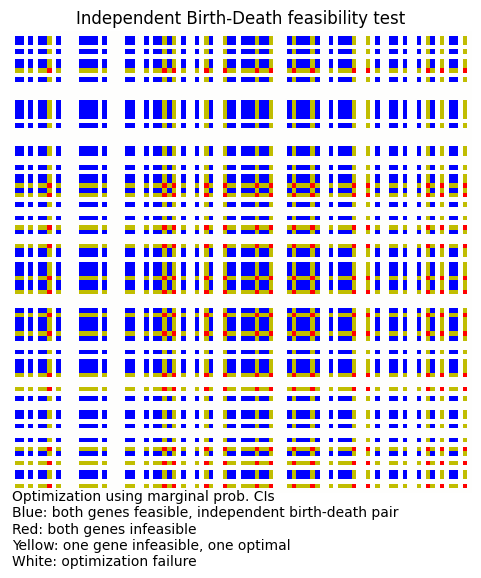

In [124]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (0.75, "y"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_BD_array_2, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Birth-Death feasibility test")
plt.axis('off')
plt.text(0.0, 115.0, "Optimization using marginal prob. CIs \
         \nBlue: both genes feasible, independent birth-death pair \
         \nRed: both genes infeasible \
         \nYellow: one gene infeasible, one optimal \
         \nWhite: optimization failure")

### Telegraph

In [105]:
# optimization analysis
odd_results_TE = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_TE_link_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

  2%|▏         | 1/50 [00:00<00:29,  1.65it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\const

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1191, in <genexpr>
    k_deg_

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 34%|███▍      | 17/50 [00:01<00:01, 20.58it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\cons

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1191, in <genexpr>
    k_deg_

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1191, in <genexpr>
    k_deg_

Optimization failed: index 1 is out of bounds for axis 0 with size 1


 80%|████████  | 40/50 [00:18<00:15,  1.55s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\cons

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 94%|█████████▍| 47/50 [00:18<00:02,  1.34it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 356, in add_constraints
    add_downsampled_marginal_CME_TE_1_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1187, in add_downsampled_marginal_CME_TE_1_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\cons

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


In [106]:
# optimization analysis
even_results_TE = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_TE_2",
        "downsampled_marginal_TE_link_2",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="D:/WLS_credentials.json"
)

  0%|          | 0/50 [00:00<?, ?it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 363, in add_constraints
    add_downsampled_marginal_CME_TE_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1243, in add_downsampled_marginal_CME_TE_2_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.p

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 363, in add_constraints
    add_downsampled_marginal_CME_TE_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1243, in add_downsampled_marginal_CME_TE_2_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1247, in <genexpr>
    k_deg_

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 44%|████▍     | 22/50 [00:00<00:00, 43.91it/s]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 363, in add_constraints
    add_downsampled_marginal_CME_TE_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1243, in add_downsampled_marginal_CME_TE_2_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\cons

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


 68%|██████▊   | 34/50 [00:46<00:46,  2.91s/it]Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 363, in add_constraints
    add_downsampled_marginal_CME_TE_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1243, in add_downsampled_marginal_CME_TE_2_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\cons

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
                       ^^^^^^^^^^^^^^^^
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\optimization.py", line 133, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 363, in add_constraints
    add_downsampled_marginal_CME_TE_2_constraints(
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1243, in add_downsampled_marginal_CME_TE_2_constraints
    model.addConstrs(
  File "src\\gurobipy\\_model.pyx", line 4087, in gurobipy._model.Model.addConstrs
  File "d:\Projects\ProjectPaper\M5R_venv\Lib\site-packages\interaction_inference\constraints.py", line 1247, in <genexpr>
    k_deg_

Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


In [107]:
# combine results of feasibility test
feasible_results_TE = []
for k in range(gene_pairs):
    feasible_results_TE.append(even_results_TE.result_dict[k]['status'])
    feasible_results_TE.append(odd_results_TE.result_dict[k]['status'])

42 Failed 
58 Feasible 
0 Infeasible


Text(0.5, 1.0, 'Independent Telegraph feasiblity tests')

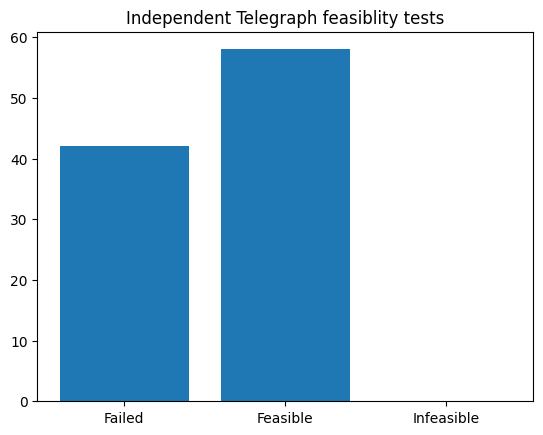

In [108]:
num_failed = (np.array(feasible_results_TE) == None).sum()
num_feasible = (np.array(feasible_results_TE) == 'OPTIMAL').sum()
num_infeasible = (np.array(feasible_results_TE) == 'INFEASIBLE').sum()

print(f"{num_failed} Failed \n{num_feasible} Feasible \n{num_infeasible} Infeasible")

plt.bar(["Failed", "Feasible", "Infeasible"], [num_failed, num_feasible, num_infeasible]);
plt.title("Independent Telegraph feasiblity tests")

In [122]:
indep_TE_array_2 = np.zeros((genes, genes))
for i in range(genes):
    for j in range(genes):

        # get feasibility results
        gene_i = feasible_results_TE[i]
        gene_j = feasible_results_TE[j]

        if gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
            indep_TE_array_2[i, j] = 0
        elif gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
            indep_TE_array_2[i, j] = 1
        elif gene_i == "INFEASIBLE" and gene_j == "OPTIMAL":
            indep_TE_array_2[i, j] = 0.75
        elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
            indep_TE_array_2[i, j] = 0.75
        else:
            indep_TE_array_2[i, j] = 0.5
# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 115.0, 'Optimization using marginal prob. CIs          \nBlue: both genes feasible, independent telegraph pair          \nRed: both genes infeasible          \nYellow: one gene infeasible, one optimal          \nWhite: optimization failure')

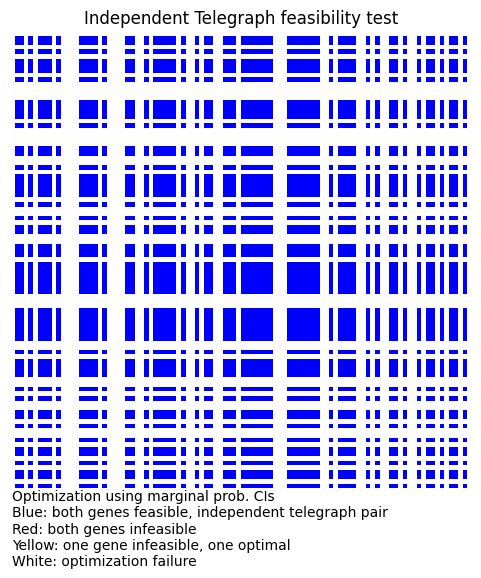

In [125]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (0.75, "y"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_TE_array_2, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Telegraph feasibility test")
plt.axis('off')
plt.text(0.0, 115.0, "Optimization using marginal prob. CIs \
         \nBlue: both genes feasible, independent telegraph pair \
         \nRed: both genes infeasible \
         \nYellow: one gene infeasible, one optimal \
         \nWhite: optimization failure")

### Optimization 'failure'

Occurs when truncation of a sample is [0, 0] because no states except x = 0 are observed more than thresh number of times (e.g. 3) e.g. Sample below only has one non-zero observed count of x = 1750

This means no CME equations can be used as constraints, as equations involve at least 2 states but bounds only exist on 1.

To solve we can artificially increase the truncation for these samples to [0, 1] (at least, possibly larger) by adding uninformative bounds (i.e. [0, 1]), but suggests a larger problem at hand

{'minM_x1_OB': 1, 'maxM_x1_OB': 14, 'minM_x2_OB': 0, 'maxM_x2_OB': 0}

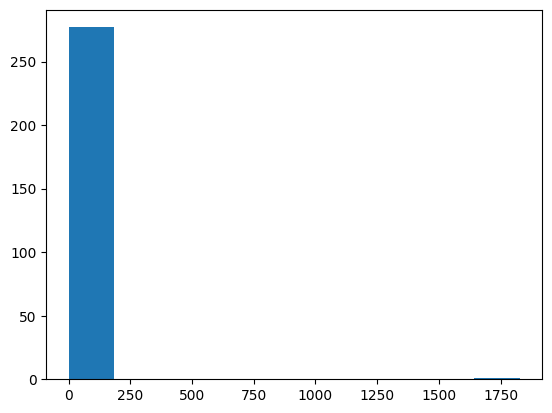

In [151]:
plt.hist([x[1] for x in dataset_single_FIB.count_dataset.loc[f'Gene-pair-{9}']])
dataset_single_FIB.truncationM_OB[f'sample-{0}']